true mu: 4
true sigma squared: 2
true nu: 20


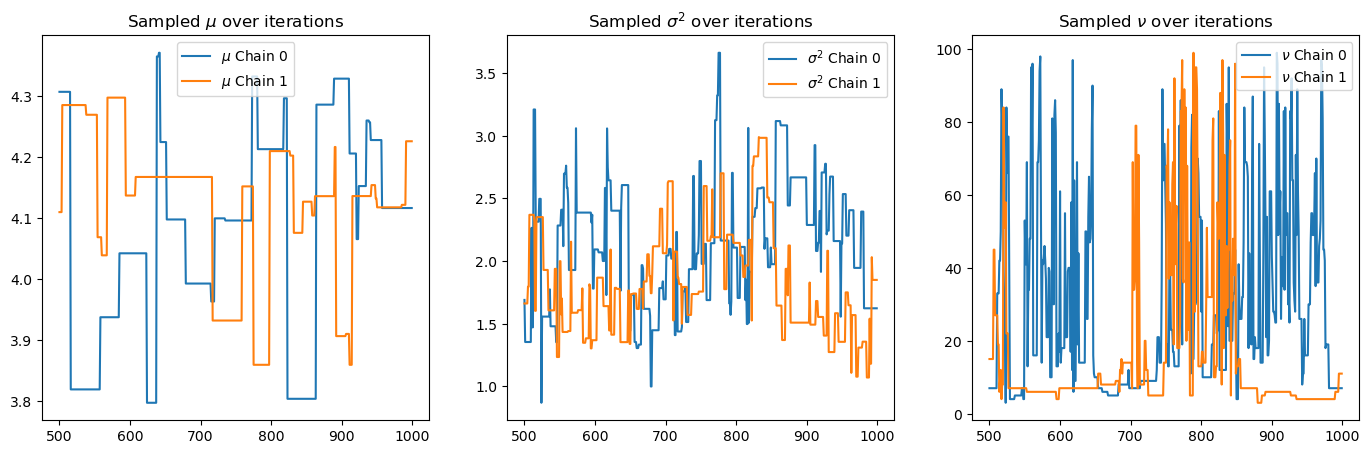

In [28]:
#Q1

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# loc is mean and scale is standard deviation
np.random.seed(365)
max_size = 100
d = 20; m = 4; s = 2; x = stats.t(df = d, loc = m, scale = s**0.5).rvs(size=max_size) 
print("true mu:", m)
print("true sigma squared:", s)
print("true nu:", d)
mu0s = [0.1, 6, 10]; tau0s = [0.1, 0.7, 10]; sigsq0s = [0.1, 8, 10]

C,G = 2,1000  # chains, Gibbs samples
def MHGibbsSample(n = max_size, mu0 = mu0s[1], \
                  tau0 = tau0s[1], sigsq0 = sigsq0s[1], C = C, G = G, m = m, s = s, x_t = x):
    x = x_t
    
    # make proposal distributions same as our priors
    mu_MH,sigsq_MH,nu_MH = np.ones([C,G]),np.ones([C,G]),np.ones([C,G])
    mu_target = lambda mu_: (sum(np.log(stats.t(loc=mu_, scale = sigsq_MH[c,g-1]**0.5, df = nu_MH[c,g-1]).pdf(x))) +\
                                        np.log(stats.norm(loc = mu0, scale = 1/tau0**0.5).pdf(mu_)))
    mu_proposal = stats.norm(loc = mu0, scale = 1/tau0**0.5)
    sigsq_target = lambda sigsq_: (sum(np.log(stats.t(loc=mu_MH[c,g-1], scale = sigsq_**0.5, df = nu_MH[c,g-1]).pdf(x))) +\
                                                np.log(stats.halfnorm(loc = 0, scale = sigsq0**0.5).pdf(sigsq_)))
    sigsq_proposal = stats.halfnorm(loc = 0, scale = sigsq0**0.5)
    nu_target = lambda nu_: (sum(np.log(stats.t(loc=mu_MH[c,g-1], scale = sigsq_MH[c,g-1]**0.5, df = nu_).pdf(x))) +\
                                                np.log((0.01 if (nu_ <= 100 and nu_ >= 1) else 0)))
    nu_proposal = stats.randint(1, 100)
    for c in range(C):
        for g in range(1,G):
            mu_tilde = mu_proposal.rvs()
            mh_calc = np.exp((mu_target(mu_tilde)-mu_target(mu_MH[c,g-1])))*\
                                  (mu_proposal.pdf(mu_MH[c,g-1]))/(mu_proposal.pdf(mu_tilde))
            acc_prob = min(1, mh_calc)
            if stats.uniform().rvs() < acc_prob:
                mu_MH[c,g] = mu_tilde
            else:
                mu_MH[c,g] = mu_MH[c,g-1]  

            sigsq_tilde = sigsq_proposal.rvs()
            mh_calc = np.exp((sigsq_target(sigsq_tilde)-sigsq_target(sigsq_MH[c,g-1])))*\
                                  (sigsq_proposal.pdf(sigsq_MH[c,g-1]))/(sigsq_proposal.pdf(sigsq_tilde))
            acc_prob = min(1, mh_calc)
            if stats.uniform().rvs() < acc_prob:
                sigsq_MH[c,g] = sigsq_tilde
            else:
                sigsq_MH[c,g] = sigsq_MH[c,g-1]  
            
            nu_tilde = nu_proposal.rvs()
            mh_calc = np.exp((nu_target(nu_tilde)-nu_target(nu_MH[c,g-1])))*\
                                  (nu_proposal.pmf(nu_MH[c,g-1]))/(nu_proposal.pmf(nu_tilde))
            acc_prob = min(1, mh_calc)
            if stats.uniform().rvs() < acc_prob:
                nu_MH[c,g] = nu_tilde
            else:
                nu_MH[c,g] = nu_MH[c,g-1]  
            
    return mu_MH, sigsq_MH, nu_MH
burn = 500
demo = 1000
samp_muMH, samp_sigsqMH, samp_nuMH = MHGibbsSample()
fig,ax = plt.subplots(1, 3, figsize=(17,5)); 
ax[0].set_title(("Sampled $\\mu$ over iterations"))
ax[1].set_title(("Sampled $\\sigma^2$ over iterations"))
ax[2].set_title(("Sampled $\\nu$ over iterations"))
for c in range(C):
    ax[0].plot(np.arange(burn, demo, dtype=int), samp_muMH[c,burn:demo], label="$\\mu$ Chain "+str(c))
    ax[1].plot(np.arange(burn, demo, dtype=int), samp_sigsqMH[c,burn:demo], label="$\\sigma^2$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), samp_nuMH[c,burn:demo], label="$\\nu$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend()



In [ ]:
muMH, sigsqMH, nuMH = np.zeros([len(alphas),G]), np.zeros([len(alphas),G]),np.zeros([len(alphas),G])
muMH_CI  = np.zeros([len(alphas),G], dtype=object)
sigsqMH_CI = np.zeros([len(alphas),G], dtype=object)
nuMH_CI  = np.zeros([len(alphas),G], dtype=object)
for n in range(burn, G):
    muMH[a, n] = np.mean(samp_muMH[0,burn-1:n])
    sigsqMH[a, n] = np.mean(samp_sigsqMH[0,burn-1:n])\
    nuMH[a, n] = np.mean(samp_nuMH[0,burn-1:n])
    muMH_CI[a, n] = tuple(np.quantile(samp_muMH[0,burn-1:n], [0.025, 0.975]))
    sigsqMH_CI[a, n] = tuple(np.quantile(samp_sigsqMH[0,burn-1:n], [0.025, 0.975]))
    nuMH_CI[a, n] = tuple(np.quantile(samp_nuMH[0,burn-1:n], [0.025, 0.975]))
fig,ax = plt.subplots(1, 3, figsize=(18,14)); 
ax[0,0].set_title(("Moving estimate of $\\mu$ over increasing iterations\nwhere $\\mu_0$ = " + str(mu0s[1]) +", $\\tau_0$ = "+ str(tau0s[1]) +", $\\sigma^2_0$ = "+ str(sigsq0s[1])))
ax[0,1].set_title(("Moving estimate of $\\sigma^2$ over increasing iterations\nwhere $\\mu_0$ = " + str(mu0s[1]) +", $\\tau_0$ = "+ str(tau0s[1]) +", $\\sigma^2_0$ = "+ str(sigsq0s[1])))
ax[0,2].set_title(("Moving estimate of $\\nu$ over increasing iterations\nwhere $\\mu_0$ = " + str(mu0s[1]) +", $\\tau_0$ = "+ str(tau0s[1]) +", $\\sigma^2_0$ = "+ str(sigsq0s[1])))

ax[0, c].plot(range(burn,G), m[c,burn:], 'k-')
lowerCI = [x[0] for x in tha_CI[c,burn:]]
upperCI = [x[1] for x in tha_CI[c,burn:]]
ax[0, c].fill_between(range(burn,G), lowerCI, upperCI)  
ax[0, c].set_xlabel("iteration number")
ax[0, c].set_ylabel("$\\mu$ estimate")



data mean (n =  50 ):  3.9645553601151557
method of moments estimate of nu (n =  50 ):  8.674306934188605


Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigsq]
>Metropolis: [nu]


Sampling 2 chains for 100 tune and 10_000 draw iterations (200 + 20_000 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


PyMC estimated nu (3%, 97% hdi), for n =  50 :  51.01395  ( 2.0 ,  94.0 ), r hat =  1.50216 .


data mean (n =  500 ):  4.019159178851537
method of moments estimate of nu (n =  500 ):  -19.985803030121033


Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigsq]
>Metropolis: [nu]


Sampling 2 chains for 100 tune and 10_000 draw iterations (200 + 20_000 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


PyMC estimated nu (3%, 97% hdi), for n =  500 :  21.22615  ( 5.0 ,  54.0 ), r hat =  1.16422 .


data mean (n =  1000 ):  4.079511622075358
method of moments estimate of nu (n =  1000 ):  -58.34555107344645


Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigsq]
>Metropolis: [nu]


Sampling 2 chains for 100 tune and 10_000 draw iterations (200 + 20_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


PyMC estimated nu (3%, 97% hdi), for n =  1000 :  28.41885  ( 8.0 ,  64.0 ), r hat =  1.08027 .


data mean (n =  10000 ):  4.042551065197503
method of moments estimate of nu (n =  10000 ):  18.656751681878585


Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>NUTS: [mu, sigsq]
>Metropolis: [nu]


Sampling 2 chains for 100 tune and 10_000 draw iterations (200 + 20_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


PyMC estimated nu (3%, 97% hdi), for n =  10000 :  22.77275  ( 15.0 ,  31.0 ), r hat =  1.00909 .




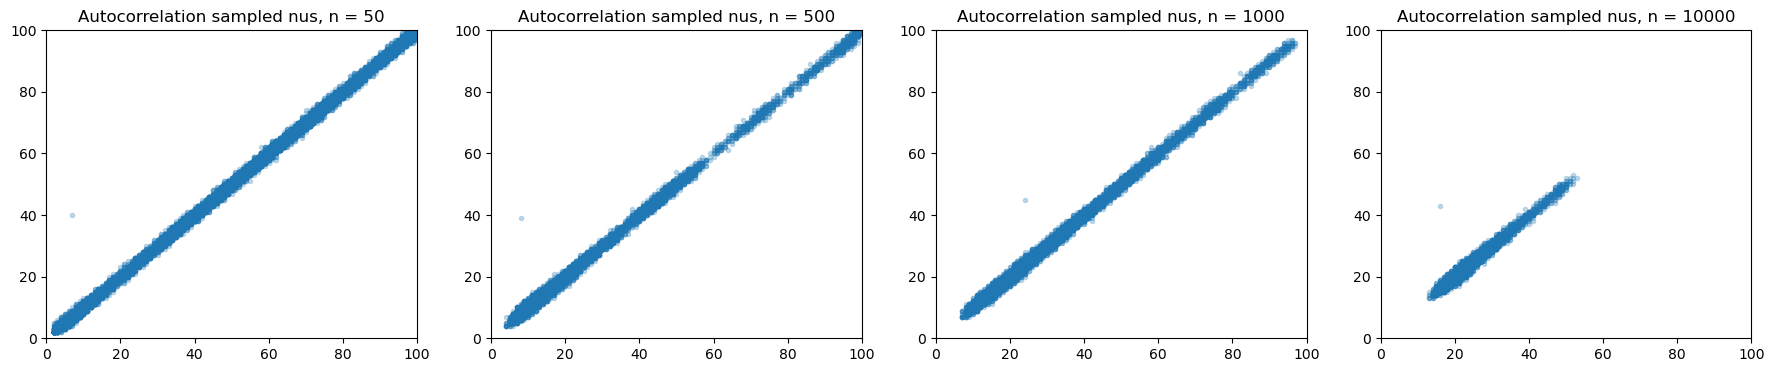

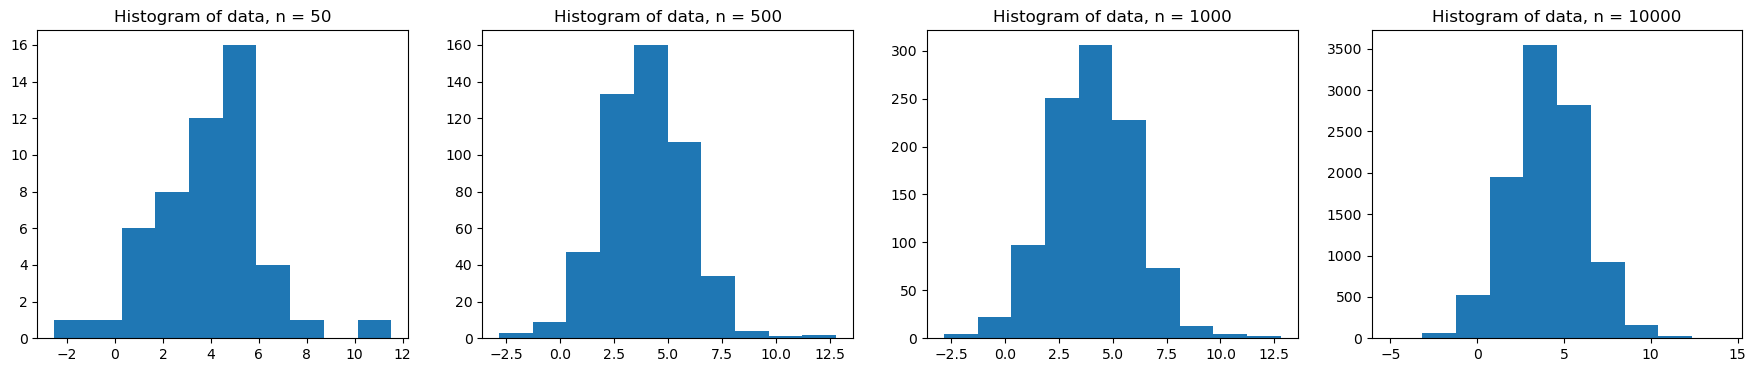

In [40]:
# Q2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pymc
import arviz as az

np.random.seed(365)
ns = [50, 500, 1000, 10000]
true_mu, true_sigsq, true_nu = 4, 4, 20 
fig,ax = plt.subplots(1,len(ns),figsize=(22,4))
fig1,ax1 = plt.subplots(1,len(ns),figsize=(22,4))
x = stats.t(df = true_nu, loc = true_mu, scale = true_sigsq**0.5).rvs(ns[-1])
def pymc_lst(i, x = x, ns = ns, ax = ax, ax1 = ax1):
    print("data mean (n = ",ns[i],"): ", np.mean(x[:ns[i]]))
    print("method of moments estimate of nu (n = ",ns[i],"): ", (2*np.std(x[:ns[i]])**2)/(np.std(x[:ns[i]])**2 - true_sigsq))
    t_distr = pymc.Model()
    with t_distr: #open a resource and guarantee that the resource will be closed when the with block completes, regardless of how the block completes.

        # Priors for unknown model parameters
        mu0 = 0  # prior belief regarding true_theta
        mu_prior_n = 5  # strength of prior belief
        tau0 = mu_prior_n*0.1
        mu = pymc.Normal("mu", mu=mu0, tau = tau0)

        sigsq0 = 8  # prior belief regarding sigma sq
        sigsq = pymc.HalfNormal("sigsq", sigma = sigsq0*0.8)

        nu0 = 10
        nu_prior_n = 4  # strength of prior belief
        nu = pymc.DiscreteUniform("nu", lower = 1, upper = 100) # this prior is uninformative (doesn't incorporate any beliefs about nu)
        # Likelihood (sampling distribution) of observations
        x_obs = pymc.StudentT("x_obs", mu=mu, sigma = sigsq**0.5, nu = nu, observed=x[:ns[i]])

    m = 10000
    with t_distr:
        # draw m posterior samples
        idata = pymc.sample(draws=m, chains=2, tune=100)
    # automatically tunes params (gives a good acceptance rate like 80%)

    mu = idata.posterior['mu'].values
    sigsq = idata.posterior['sigsq'].values
    nu = idata.posterior['nu'].values
    # bayesian inference
    summ = az.summary(idata, round_to=5)
    print("PyMC estimated nu (3%, 97% hdi), for n = ", ns[i],": ", summ["mean"]["nu"], 
          " (", summ["hdi_3%"]["nu"],", ", summ["hdi_97%"]["nu"], "), r hat = ", summ["r_hat"]["nu"], ".\n\n")
    # diagnostics
    ax[i].plot(nu.ravel()[:-1], nu.ravel()[1:], '.', alpha=0.25)
    ax[i].set_xlim(0, 100)
    ax[i].set_ylim(0, 100)
    ax[i].set_title(("Autocorrelation sampled nus, n = " + str(ns[i])))
    ax1[i].hist(x[:ns[i]])
    ax1[i].set_title(("Histogram of data, n = " + str(ns[i])))
    
pymc_lst(0)
pymc_lst(1)
pymc_lst(2)
pymc_lst(3)

For small $n$: 
- $\hat{r}$ is far from 1, indicating poor chain agreement 
- The 94% credible interval is wider
- estimated $\nu$ is generally far from our target value\
    These can be explained when we observe their poor method of moments estimates of $\nu$. This shows that for a small sample, the data doesn't reflect our desidered distribution well and each data point is worth more, producing an unstable characterization of our desired distribution. The result is Metropolis-Hastings proposals of high variance and samples that approximate data with a shape unreflective of our desired distribution. Therefore, we get less credible estimates with poor replicability across chains.
    
For large $n$:
- $\hat{r}$ is close to 1, indicating chain agreement 
- The 94% credible interval is narrower
- estimated $\nu$ iscloser to our target value\
    The autocorrelation plots show the sampled data is concentrated closer to our desired $\nu$ in comparison to samples with small $n$. This is because our many data points produce a stable characterization of our desired distribution, so we are less likely to propose and accept values that would be far into the tails of our desired distribution. 

### Q3

$p(y_i|\nu) = \int p(y_i|\tau_i) p(\tau_i|\nu)  d\tau_i = \int \sqrt{\frac{\tau_i}{2\pi}}e^{-\frac{1}{2}\tau_i y_i^2} \frac {\frac{\nu}{2}^{\frac{\nu}{2}}}{\Gamma \left(\frac{\nu}{2}\right)} \tau_i^{\frac{\nu}{2}-1}e^{-\frac{\nu}{2}\tau_i} d\tau_i = (\frac{\frac{\nu}{2}^{\frac{\nu}{2}}}{\sqrt{2\pi}\Gamma(\frac{\nu}{2})})(\frac{\Gamma(\frac{\nu+1}{2})}{\frac{y_i^2+\nu}{2}^{\frac{\nu+1}{2}}})\int Gamma(\alpha = \frac{\nu+1}{2}, \lambda = \frac{y_i^2+\nu}{2}).pdf(\tau_i)d\tau_i = \frac{\Gamma(\frac{\nu+1}{2})}{\sqrt{\nu\pi}\Gamma(\frac{\nu}{2})}(1+\frac{y_i^2}{\nu})^{-\frac{\nu+1}{2}} = t(df = \nu, loc = 0, scale = 1).pdf(y_i)$

This distribution describes a random variable, $Y_i|\nu \sim t(df=\nu)$. Since a posterior predictive distribution is the expectation of a random variable with respect to the posterior of its conditional data, we can say that sampling from $p(y_i|\nu)$ gives us $\hat{y_i}$'s that account for our uncertainty about $\tau_i$ when we are given $p(y_i|\tau_i)$ and $p(\tau_i|\nu)$ but only know $\nu$. This is different from the posterior distribution $p(y_i|\tau_i,\nu)$ since in order to sample from this distribution when we don't know $\tau_i$, we have to sample from $p(\tau_i|\nu)$ and use a point estimate for $\tau_i$ (which erases all of our uncertainty about $\tau_i$, resulting in an overly confident estimate) or implement a Gibbs sampler (computationally intensive). Using the posterior predictive distribution gives us a justifiable, sample-able distribution for a random variable of interest that also incorporates our beliefs.